# Seasonality check

In [15]:
from pandas import DataFrame, read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.dates as mdates
from darts import TimeSeries
from sklearn.linear_model import LinearRegression

Load the series

Date
2019-08-17    30.5
2019-08-18    31.1
2019-08-19    31.7
2019-08-20    30.8
2019-08-21    31.8
Name: Maximum temperature, dtype: float64
Dataset does not contain NaN values


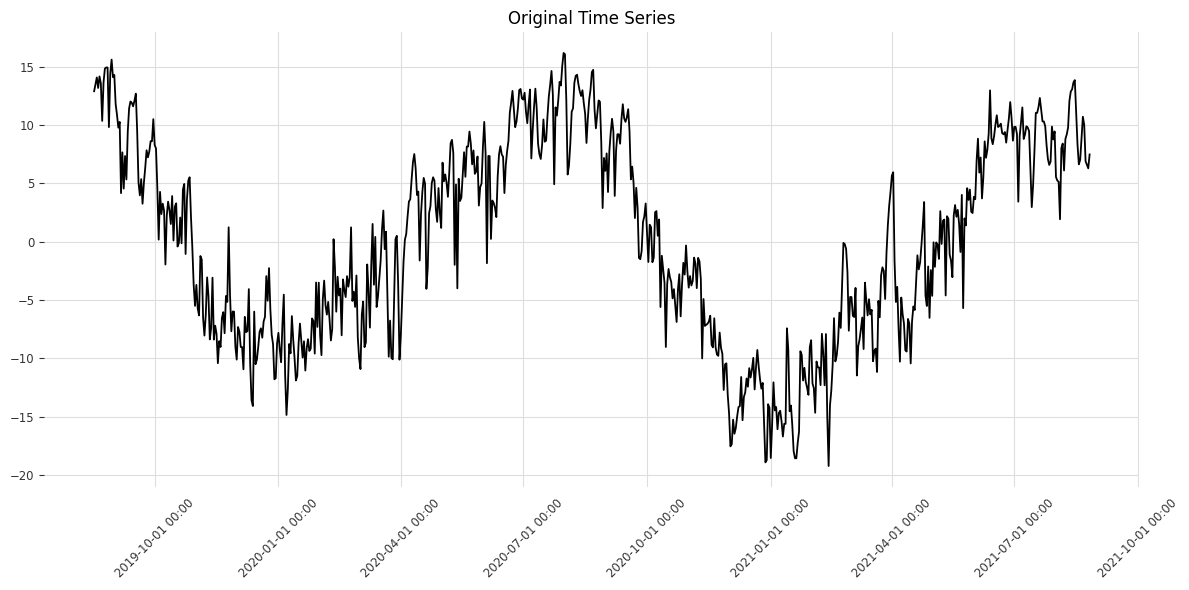

In [16]:
series = read_csv('../dataset/Temperature/temperature_milan.csv', header=0, index_col=0, parse_dates=True).squeeze("columns")

series = series['Maximum temperature']
print(series.head())

# Check for NaN values
nan_check = series.isna().any().any()
if nan_check:
    print("Dataset contains NaN values")
    upsampled= series.resample('D').mean()
    series = upsampled.interpolate(method = 'linear')
else:
    print("Dataset does not contain NaN values")

#series = series[65:168]
#0.0000115740741, 1.6534391534391535e-06, 4.133597883597884e-07, 3.21502058e-8
sampling_rate = 0.0000115740741
n = len(series)

# Create a date range with the same start and end dates and frequency as the original series
time_index = series.index

model = LinearRegression()
y = np.array([x for x in range(0, len(series))])
model.fit(y.reshape(-1, 1), series)
pred = model.predict(y.reshape(-1, 1))
series = series - pred

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_index, series)

# Ruotare e formattare le etichette dell'asse x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)  # Rotazione delle etichette
plt.title('Original Time Series')
plt.tight_layout()
plt.show()

# for i in range(0, len(series)-12, 12):
#     end = i + 12
#     print(end)
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.plot(time_index[i:end], series[i:end])

#     # Ruotare e formattare le etichette dell'asse x
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#     plt.xticks(rotation=45)  # Rotazione delle etichette

#     plt.tight_layout()
#     plt.show()

Fourier

La frequenza 1.6534391534391535e-06 Hz è presente con ampiezza 0.1432800744380894, frequenza [1.65567052e-06] Hz


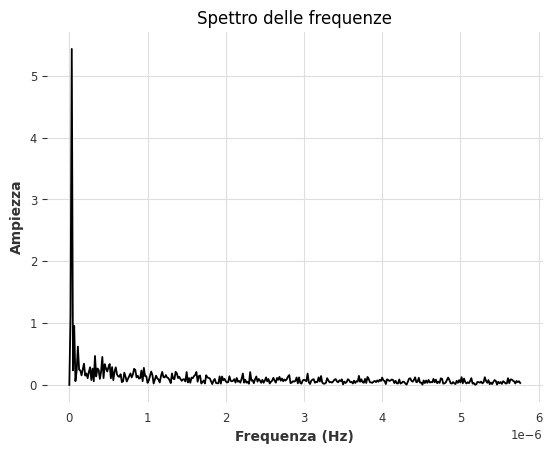

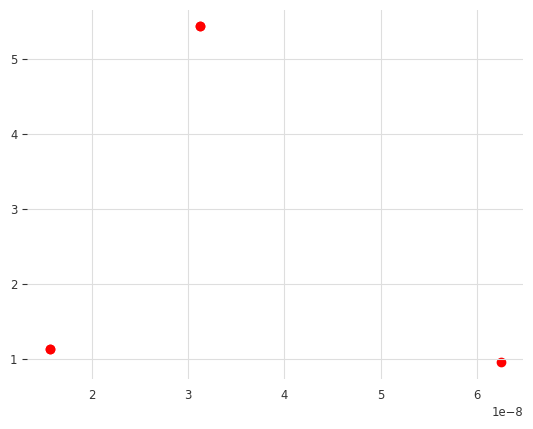

Dominant Frequencies: [6.24781328e-08 1.56195332e-08 1.56195332e-08 3.12390664e-08
 3.12390664e-08]
mean amplitude 2.8149566338407923


In [17]:
X= np.asarray(series).flatten()

# Calcolo della FFT
fft_data = np.fft.fft(X)
frequencies = np.fft.fftfreq(n, d=1/sampling_rate)


# Calcolo dell'ampiezza
amplitude = np.abs(fft_data) / n

# Frequenza specifica da cercare (in Hz)
target_frequency = 1.6534391534391535e-06


# Trova l'indice della frequenza più vicina
#idx = (np.abs(frequencies - target_frequency)).argmin()
N=1
idx = np.argsort(np.abs(frequencies - target_frequency))[:N]

# Verifica se l'ampiezza della frequenza specifica supera una soglia
threshold = 0.001  # Puoi regolare questa soglia
if np.mean(amplitude[idx]) > threshold:
    print(f"La frequenza {target_frequency} Hz è presente con ampiezza {np.mean(amplitude[idx])}, frequenza {frequencies[idx]} Hz")
else:
    print(f"La frequenza {target_frequency} Hz non è presente o è sotto la soglia")

# Grafico dell'ampiezza delle frequenze
plt.plot(frequencies[:n//2], amplitude[:n//2])  # Solo la metà positiva delle frequenze
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Ampiezza')
plt.title('Spettro delle frequenze')
plt.show()

# Find indices of the top N peaks
N = 5  # Number of dominant frequencies to identify
top_indices = np.argsort(np.abs(fft_data))[-N:]
indices_to_remove = np.where(frequencies[top_indices] == 0.0)
filtered_indices = np.delete(top_indices, indices_to_remove)


# Extract corresponding frequencies
dominant_frequencies = np.abs(frequencies[filtered_indices])

# Highlight dominant frequencies
plt.scatter(dominant_frequencies, amplitude[filtered_indices], color='red')

plt.show()

print("Dominant Frequencies:", dominant_frequencies)


print("mean amplitude",np.mean(amplitude[filtered_indices]))


ACF

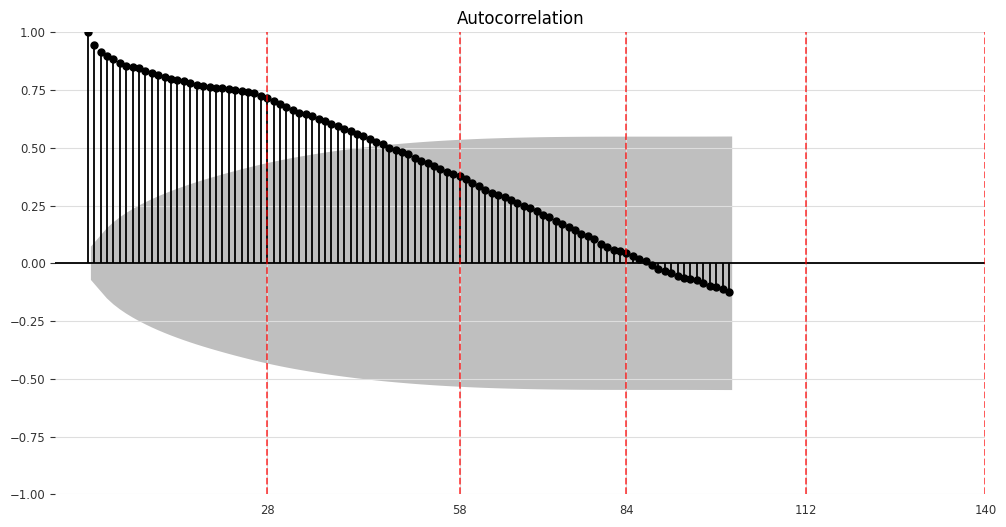

In [18]:
X= np.asarray(series).flatten()
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(X, lags=100, ax= ax)
highlight_lags = [28, 58, 84, 112, 140]
ax.set_xticks(highlight_lags)
ax.set_xticklabels(highlight_lags)
for lag in highlight_lags:
    ax.axvline(x=lag, color='red', linestyle='--', alpha=0.7)
plt.show()

Periodogram plot

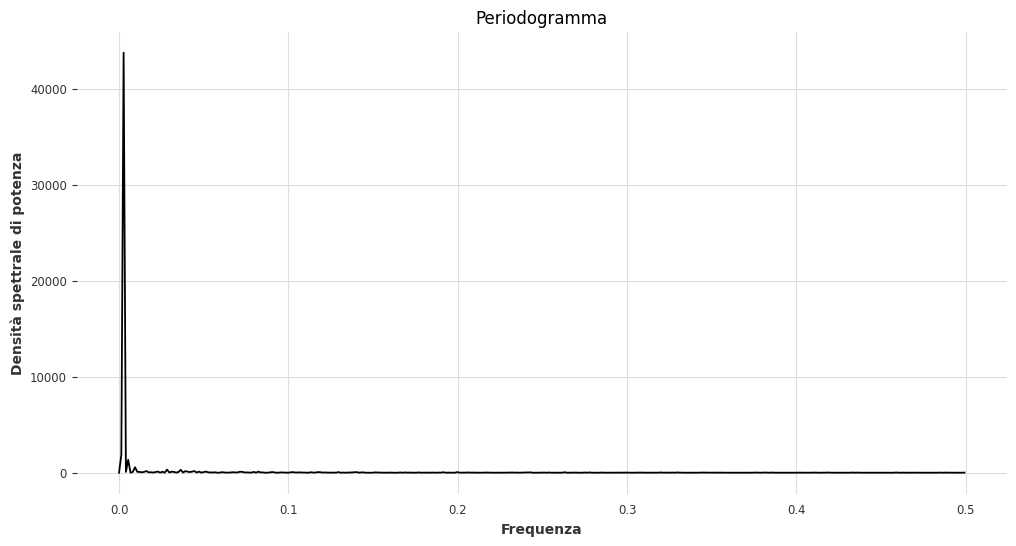

In [19]:
X= np.asarray(series).flatten()
f, Pxx_den = periodogram(X)
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx_den)
plt.title('Periodogramma')
plt.xlabel('Frequenza')
plt.ylabel('Densità spettrale di potenza')
plt.show()